<a href="https://colab.research.google.com/github/VanHoann/Yelp_Dataset_Challenges/blob/main/Sentiment_Analysis/Legacy/Baseline2_RNN%2BWord2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Set up

In [1]:
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add, Bidirectional, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
!pip install keras-layer-normalization
from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

# just to ignore the matplotlib warnings to make the plots look better
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4668 sha256=75c352163868b87372724f7d521a7eb1451c07018c0540104ea8f7a37e9cf6ef
  Stored in directory: /root/.cache/pip/wheels/85/5d/1c/2e619f594f69fbcf8bc20943b27d414871c409be053994813e
Successfully built keras-layer-normalization


Load data


In [2]:
#Helper function
def load_data(split_name='train', columns=['text', 'stars'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.
        
        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "stars" column is the labels (sentiment). 
        If you like, you are free to use columns other than "text" for prediction.
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

'''def load_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of ids, a list of reviews, a list of labels
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = pd.read_csv(file_name)

    return df["id"], df["text"], df["label"]'''

def load_labels(file_name):
    """
    :param file_name: a file name, type: str
    return a list of labels
    """
    return pd.read_csv(file_name)["label"]

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["id", "label"]
    df.to_csv(file_name, index=False)

In [3]:
data_dir = "https://raw.githubusercontent.com/VanHoann/Yelp_Dataset_Challenges/main/Sentiment_Analysis/data"

train_df = load_data('train', columns=['text', 'stars', 'review_id'], folder=data_dir)
valid_df = load_data('valid', columns=['text', 'stars', 'review_id'], folder=data_dir)
test_df = load_data('test', columns=['text','review_id'], folder=data_dir)

select [text, stars, review_id] columns from the train split
Success
select [text, stars, review_id] columns from the valid split
Success
select [text, review_id] columns from the test split
Success


In [4]:
train_df['text length'] = train_df['text'].apply(len)
train_df.head()

,text,stars,review_id,text length
0,I've been here a handful of times now and I've...,5,oxj0_2jKOqQFIWEYRjWi6g,699
1,The service was terrible. The food was just ok...,1,gZITaUSvzBUijZvNGXO_Cg,98
2,Alil pricey for the location but completly get...,4,ov2ohuP2bPJI35sscGGJpw,95
3,Don't get your car washed here. Paid 11 and my...,1,LFJGPIrbR7U_g3oavotkXg,178
4,Cute but tight. Not expensive and creative. I ...,5,hUoRKiGTnMV51R6pQSYovQ,188


###Visualize data

In [5]:
import seaborn as sns

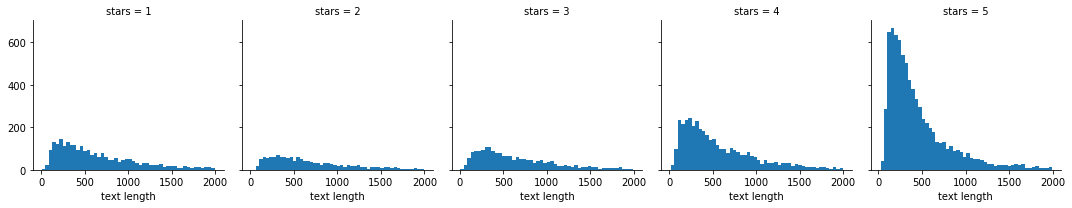

In [6]:
g = sns.FacetGrid(data=train_df[ train_df['text length']<2000 ], col='stars')
g.map(plt.hist, 'text length', bins=50)

*   There is a high number of 4-star and 5-star reviews 
*   Text length distribution is similar across 5 ratings (skewed a lot in 4&5-star)


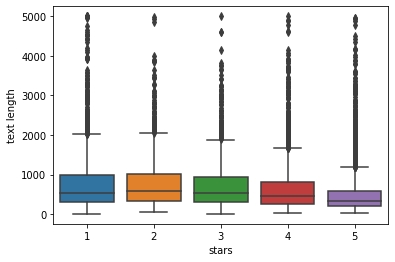

In [7]:
sns.boxplot(x='stars', y='text length', data=train_df)



*  Text lengths are longer for fewer stars
*  Too many outliers -> text length is not usefull

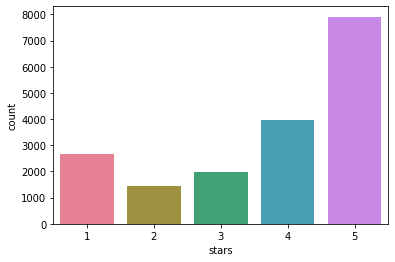

In [8]:
sns.countplot('stars', data = train_df, palette="husl")

The data for 2,3,4 stars is too little -> hard to train model to differentiate between them

###Pre-processing helper functions

In [9]:
def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

'''def remove_contractions(tokens):
    con = {"don't", "doesn't", "wouldn't", "won't", "isn't", "aren't", "didn't", "was't", " weren't", "shouldn't", "n't"}
    result = []
    for token in tokens:
        if token in con:
            result.append("not")
        else:
            result.append(token)
    return result'''

'''def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results'''

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import string
def filter_punctuations(tokens):
    return [token for token in tokens if token not in string.punctuation]

'''def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector'''  

def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param feats: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out
    :param max_size: the max size of feature dict
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]  #output n highest-freq (word, cnt)
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

###RNN classifier

In [10]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a RNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # recurrent layers document: https://keras.io/layers/recurrent
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=False)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

###Preprocessing

In [11]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(18000, 4)
(2000, 3)
(4000, 2)


Tokenize texts

In [12]:
train_df['tokens'] = train_df['text'].map(tokenize).map(filter_stopwords).map(filter_punctuations).map(lower)
valid_df['tokens'] = valid_df['text'].map(tokenize).map(filter_stopwords).map(filter_punctuations).map(lower)
test_df['tokens'] = test_df['text'].map(tokenize).map(filter_stopwords).map(filter_punctuations).map(lower)

In [13]:
print(test_df.head())

                                                text               review_id  \
0  OMG! I'm an avid spray tanner and have been al...  I77zZlSdCFAClxdjHwPcxw   
1  Sets the standard. Authentic. Outstanding. Cou...  ioFNKarf29KGjRZdH0qC8Q   
2  Came on 7/23/2014 with a group of 10 - service...  9429anmcYIcaEcMptJCNKQ   
3  I love Bobs Subs! Tasty n made to order...yum!...  PsUCdt7PKjzgBC0c7xXhJA   
4  This is my hotel of choice on the strip.  I re...  GQBlykKyShQcNeu2ivLdSA   

                                              tokens  
0  [omg, i, 'm, avid, spray, tanner, valley, with...  
1  [sets, standard, authentic, outstanding, could...  
2  [came, 7/23/2014, group, service, awful, food,...  
3  [i, love, bobs, subs, tasty, n, made, order, ....  
4  [this, hotel, choice, strip, i, really, like, ...  


In [14]:
print(train_df['tokens'][5]) #all 'n't' i.e. 'not' are maintained

['my', 'first', 'time', 'vegas', 'however', 'first', 'time', 'buffet', 'i', 'watched', 'tube', 'read', 'reviews', 'talked', 'friends', 'came', 'conclusion', 'place', 'best', 'food', 'money', 'it', 'wasnt', 'terrible', "n't", 'good', 'most', 'food', 'cold', 'undesirable', 'the', 'wicked', 'chicken', 'wings', 'good', 'the', 'bone', 'marrow', 'nice', 'touch', 'the', 'pho', 'flavorful', 'the', 'omelet', 'delicious', 'but', 'carving', 'station', 'meat', 'cold', 'the', 'pasta', 'bland', 'the', 'sushi', 'like', 'grocery', 'store', 'the', 'deserts', "n't", 'anything', 'crazy', 'delicious', 'honestly', 'items', 'okay', 'we', 'waited', 'hours', 'eat', 'okay', 'food', 'sure', 'i', 'left', 'full', 'i', 'would', 'much', 'rather', 'checked', 'better', 'las', 'vegas', 'food', 'i', 'came', 'i', 'saw', 'ill', 'go', 'somewhere', 'else', 'next', 'time']


In [15]:
min_freq = 3 #select words with frequencies >= 3
feats_dict = get_feats_dict(
    chain.from_iterable(list(train_df['tokens'])+list(valid_df['tokens'])))
    #,min_freq=min_freq)

Size of features: 45619


In [16]:
len(list(train_df['tokens'])+list(valid_df['tokens']))

20000

In [17]:
print(dict(list(feats_dict.items())[0:10]))

{'i': 0, 'the': 1, "n't": 2, "'s": 3, 'food': 4, 'good': 5, 'place': 6, 'great': 7, 'service': 8, 'we': 9}


In [18]:
max_len = 250

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_df['tokens']])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_df['tokens']])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_df['tokens']])


# convert labels to label_matrix
num_classes = 5
# convert each label to a one-hot vector, and then stack vectors as a matrix
train_label_matrix = tf.keras.utils.to_categorical(train_df['stars']-1, num_classes=num_classes)
valid_label_matrix = tf.keras.utils.to_categorical(valid_df['stars']-1, num_classes=num_classes)

In [19]:
print(test_feats_matrix.shape)

(4000, 250)


In [20]:
print(train_feats_matrix.shape)
print(train_feats_matrix[0])
print(train_label_matrix.shape)
print(train_label_matrix[:3])

(18000, 250)
[    0    25  2670   113     0    25    44   263     1     4    37     5
   576   272    81   273    67   174   260 14144   171  3337 14144  1830
    26     0   599   756  4401     0 14144   171     1   550    34   159
    78   933     0    37   383  1068   131     1   550    47   959   142
   143    67   328  2740     0    25    21   257  5507   135   368    68
    78   199     0    25   482   279    45    12   852   205   177     5
     1   576    37    43    26    19   223     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0  

###Simple RNN

####LSTM

In [21]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 8ms/step - loss: 1.4816 - accuracy: 0.4555
training loss: 1.514910101890564 training accuracy 0.44655555486679077
test loss: 1.4815969467163086 test accuracy 0.4555000066757202


In [22]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.4643    0.0461    0.0839       282
           2     0.0000    0.0000    0.0000       136
           3     0.0000    0.0000    0.0000       212
           4     0.0000    0.0000    0.0000       466
           5     0.4556    0.9934    0.6247       904

    accuracy                         0.4555      2000
   macro avg     0.1840    0.2079    0.1417      2000
weighted avg     0.2714    0.4555    0.2942      2000



####GRU

In [23]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="gru", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  gru_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 7ms/step - loss: 1.0166 - accuracy: 0.6235
training loss: 0.5965202450752258 training accuracy 0.7858889102935791
test loss: 1.0166301727294922 test accuracy 0.6234999895095825


In [24]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.7257    0.7411    0.7333       282
           2     0.2876    0.3235    0.3045       136
           3     0.4101    0.4198    0.4149       212
           4     0.4804    0.3155    0.3808       466
           5     0.7317    0.8385    0.7814       904

    accuracy                         0.6235      2000
   macro avg     0.5271    0.5277    0.5230      2000
weighted avg     0.6080    0.6235    0.6100      2000



####Bi-directional LSTM

In [25]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 13ms/step - loss: 1.0810 - accuracy: 0.6275
training loss: 0.8828385472297668 training accuracy 0.7360000014305115
test loss: 1.0810298919677734 test accuracy 0.6274999976158142


In [26]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.6250    0.8156    0.7077       282
           2     0.0000    0.0000    0.0000       136
           3     0.4831    0.2689    0.3455       212
           4     0.4492    0.4270    0.4378       466
           5     0.7180    0.8507    0.7787       904

    accuracy                         0.6275      2000
   macro avg     0.4551    0.4724    0.4539      2000
weighted avg     0.5685    0.6275    0.5904      2000



####Comparison

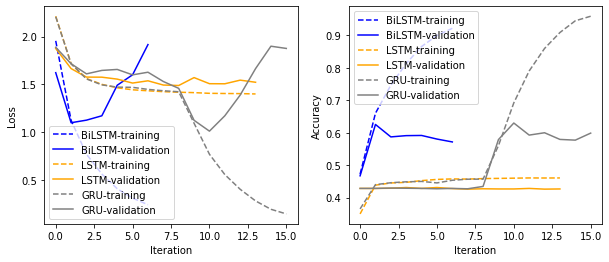

In [27]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(bilstm_history.history["loss"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM-validation", color="blue")
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["loss"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_loss"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM-validation", color="blue")
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["accuracy"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_accuracy"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Not so good, but all models are all stable and fast to train

###RNN with Word Embeddings

####GRU+FastText (best combination)

In [28]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!cp fasttext ../
%cd ..

Cloning into 'fastText'...
remote: Enumerating objects: 3930, done.
remote: Counting objects: 100% (944/944), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 3930 (delta 854), reused 804 (delta 804), pack-reused 2986
Receiving objects: 100% (3930/3930), 8.24 MiB | 39.81 MiB/s, done.
Resolving deltas: 100% (2505/2505), done.
/content/fastText
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/args.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/autotune.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/matrix.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/dictionary.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/loss.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/productquantizer.cc
c++ -pthread -std=c++11 -march=native -O3 -funroll-loops -DNDEBUG -c src/densematrix.cc
c++ -pthread -std=c++11 -march=nati

In [29]:
pwd

'/content'

The code below is to write save training texts into a 'reviews.txt' where each line is a sentence or a review

In [30]:
with open("reviews.txt", "w") as f:
    for x in train_df['tokens']:
        sent = [w if w in feats_dict else "<unk>" for w in x]
        f.write(" ".join(sent))
        f.write("\n")
    for x in valid_df['tokens']:
        sent = [w if w in feats_dict else "<unk>" for w in x]
        f.write(" ".join(sent))
        f.write("\n")

In [31]:
!./fastText/fasttext skipgram -input reviews.txt -output word2vec -dim 100 -minCount 3 -epoch 10

Read 1M words
Number of words:  17140
Number of labels: 0
Progress: 100.0% words/sec/thread:   11463 lr:  0.000000 avg.loss:  2.229092 ETA:   0h 0m 0s


Build embedding matrix

In [33]:
embedding_matrix = np.zeros((len(feats_dict), 100), dtype=np.float32)
with open("word2vec.vec", "r") as f:
    n_words, n_dim = f.readline().split()
    n_words, n_dim = int(n_words), int(n_dim) 
    print("number of words:", n_words, "word dimension:", n_dim)
    while True:
        line = f.readline()
        if not line:
            break
        word, vec = line.split(" ", 1)
        word_idx = feats_dict.get(word, -1)
        if word_idx != -1:
            embedding_matrix[word_idx] = np.array(vec.split(), dtype=np.float32)

number of words: 17140 word dimension: 100


In [34]:
print(embedding_matrix[:5])

[[ 2.9940e-01  1.0787e-01  2.6570e-01 -2.0154e-01  4.4366e-02  1.5901e-01
   7.4728e-02 -1.5945e-01  9.4917e-02  1.1043e-01 -6.6370e-02  1.7468e-01
  -2.8960e-02  5.1952e-02 -1.9535e-01 -1.7225e-01  2.3413e-01 -4.7336e-02
  -1.7992e-01 -3.8821e-02  7.8607e-02  3.5578e-01 -1.2861e-02 -1.5123e-01
  -1.2822e-01 -3.9803e-02 -5.8060e-02  1.2697e-01  4.5375e-03  1.0228e-01
  -1.6500e-01 -2.9522e-02  1.2817e-01  5.2963e-03 -1.1983e-01 -1.9379e-02
   9.0288e-02 -5.6694e-01 -3.0226e-01 -1.5199e-01 -1.9520e-01  1.6754e-01
   1.1331e-01 -3.2007e-01 -1.0674e-01 -2.1841e-01  1.0829e-01 -3.4203e-01
   3.6338e-02  1.9256e-01  1.2707e-01  5.9673e-02  2.1937e-01  2.2118e-02
  -2.6571e-01  1.1348e-01 -2.3028e-01 -2.2358e-01 -1.4083e-01  1.2715e-01
  -8.1688e-02 -2.0647e-01  1.8050e-01 -1.7363e-01  1.2856e-01 -2.9429e-02
  -1.4810e-01 -6.8222e-02  2.5054e-01 -2.1676e-02  4.4733e-03  5.0836e-02
  -5.1425e-02  2.7037e-02  6.0986e-02  6.2140e-02  2.0335e-01  1.5712e-01
  -8.2894e-02 -1.3846e-01  7.4277e-02 

In [35]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score

class Metrics(Callback):
  
  def on_train_begin(self, logs={}):
    self.f1s = []
 
  def on_epoch_end(self, epoch, logs={}):
    val_predict = np.argmax(self.model.predict(valid_feats_matrix), axis = 1) + 1
    val_targ = valid_df["stars"]
    f1 = f1_score(val_targ, val_predict, average='macro')
    self.f1s.append(f1)
    print("\nmacro-f1: ",f1)
    return
 
metrics = Metrics()
#pred = np.argmax(self.model.predict(valid_feats_matrix), axis = 1) + 1

def f1(y_true, y_pred):
    val_predict = np.argmax(y_true, axis = 1) + 1
    val_targ = valid_df["stars"]
    f1 = f1_score(val_targ, val_predict, average='macro')
    return f1

Save all models

In [38]:
models_path = "/models"
checkpoint_path = os.path.join(models_path, "cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

In [41]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="gru", num_rnn_layers=1, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    verbose=0)#,
    #save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  gru_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=40, batch_size=100, verbose=1,
                    callbacks=[checkpointer, metrics])#, earlystopping]) #train for 40 epochs

Epoch 1/40
162/162 [==============================] - ETA: 0s - loss: 2.2008 - accuracy: 0.3551


macro-f1:  0.12601217227555547
162/162 [==============================] - 26s 150ms/step - loss: 2.2008 - accuracy: 0.3551 - val_loss: 1.8627 - val_accuracy: 0.4300
Epoch 2/40
161/162 [============================>.] - ETA: 0s - loss: 1.7033 - accuracy: 0.4381


macro-f1:  0.1325960435378718
162/162 [==============================] - 20s 125ms/step - loss: 1.7031 - accuracy: 0.4379 - val_loss: 1.6542 - val_accuracy: 0.4294
Epoch 3/40
161/162 [============================>.] - ETA: 0s - loss: 1.5591 - accuracy: 0.4420


macro-f1:  0.13382747295790773
162/162 [==============================] - 19s 120ms/step - loss: 1.5591 - accuracy: 0.4420 - val_loss: 1.6114 - val_accuracy: 0.4306
Epoch 4/40
162/162 [==============================] - ETA: 0s - loss: 1.5058 - accuracy: 0.4436


macro-f1:  0.13700254731136519
162/162 [==============================] - 19s 120ms/step - loss: 1.5058 - accuracy: 0.4436 - val_loss: 1.6184 - val_accuracy: 0.4306
Epoch 5/40
161/162 [============================>.] - ETA: 0s - loss: 1.4961 - accuracy: 0.4352


macro-f1:  0.14385767061155902
162/162 [==============================] - 19s 117ms/step - loss: 1.4961 - accuracy: 0.4352 - val_loss: 1.5188 - val_accuracy: 0.4322
Epoch 6/40
161/162 [============================>.] - ETA: 0s - loss: 1.3711 - accuracy: 0.4738


macro-f1:  0.3746657521139555
162/162 [==============================] - 20s 122ms/step - loss: 1.3702 - accuracy: 0.4739 - val_loss: 1.0537 - val_accuracy: 0.5767
Epoch 7/40
159/162 [============================>.] - ETA: 0s - loss: 0.9927 - accuracy: 0.6013


macro-f1:  0.3772703194154425
162/162 [==============================] - 23s 145ms/step - loss: 0.9927 - accuracy: 0.6005 - val_loss: 1.2289 - val_accuracy: 0.5400
Epoch 8/40
160/162 [============================>.] - ETA: 0s - loss: 0.9025 - accuracy: 0.6337


macro-f1:  0.5012113366403029
162/162 [==============================] - 19s 118ms/step - loss: 0.9027 - accuracy: 0.6340 - val_loss: 0.9440 - val_accuracy: 0.6267
Epoch 9/40
162/162 [==============================] - ETA: 0s - loss: 0.8734 - accuracy: 0.6412


macro-f1:  0.5491935775650172
162/162 [==============================] - 20s 122ms/step - loss: 0.8734 - accuracy: 0.6412 - val_loss: 0.9202 - val_accuracy: 0.6206
Epoch 10/40
161/162 [============================>.] - ETA: 0s - loss: 0.8579 - accuracy: 0.6474


macro-f1:  0.5207619666578384
162/162 [==============================] - 18s 115ms/step - loss: 0.8578 - accuracy: 0.6475 - val_loss: 0.8858 - val_accuracy: 0.6511
Epoch 11/40
162/162 [==============================] - ETA: 0s - loss: 0.8331 - accuracy: 0.6562


macro-f1:  0.542039055958597
162/162 [==============================] - 20s 122ms/step - loss: 0.8331 - accuracy: 0.6562 - val_loss: 0.9148 - val_accuracy: 0.6522
Epoch 12/40
159/162 [============================>.] - ETA: 0s - loss: 0.8227 - accuracy: 0.6611


macro-f1:  0.556155838980305
162/162 [==============================] - 19s 117ms/step - loss: 0.8243 - accuracy: 0.6606 - val_loss: 0.9342 - val_accuracy: 0.6261
Epoch 13/40
161/162 [============================>.] - ETA: 0s - loss: 0.8096 - accuracy: 0.6629


macro-f1:  0.5541364278819298
162/162 [==============================] - 19s 117ms/step - loss: 0.8089 - accuracy: 0.6629 - val_loss: 0.9343 - val_accuracy: 0.6167
Epoch 14/40
160/162 [============================>.] - ETA: 0s - loss: 0.7920 - accuracy: 0.6701


macro-f1:  0.5082897537779629
162/162 [==============================] - 19s 117ms/step - loss: 0.7923 - accuracy: 0.6702 - val_loss: 1.0012 - val_accuracy: 0.6211
Epoch 15/40
159/162 [============================>.] - ETA: 0s - loss: 0.7787 - accuracy: 0.6761


macro-f1:  0.5197581191603549
162/162 [==============================] - 20s 123ms/step - loss: 0.7790 - accuracy: 0.6762 - val_loss: 0.9684 - val_accuracy: 0.6394
Epoch 16/40
160/162 [============================>.] - ETA: 0s - loss: 0.7619 - accuracy: 0.6839


macro-f1:  0.5011303153898768
162/162 [==============================] - 19s 117ms/step - loss: 0.7616 - accuracy: 0.6840 - val_loss: 1.0163 - val_accuracy: 0.6078
Epoch 17/40
162/162 [==============================] - ETA: 0s - loss: 0.7475 - accuracy: 0.6877


macro-f1:  0.5637848177792882
162/162 [==============================] - 19s 115ms/step - loss: 0.7475 - accuracy: 0.6877 - val_loss: 0.8873 - val_accuracy: 0.6533
Epoch 18/40
160/162 [============================>.] - ETA: 0s - loss: 0.7371 - accuracy: 0.6937


macro-f1:  0.5033599475739885
162/162 [==============================] - 19s 115ms/step - loss: 0.7371 - accuracy: 0.6942 - val_loss: 0.9768 - val_accuracy: 0.6244
Epoch 19/40
160/162 [============================>.] - ETA: 0s - loss: 0.7137 - accuracy: 0.7027


macro-f1:  0.4889954225124116
162/162 [==============================] - 19s 120ms/step - loss: 0.7130 - accuracy: 0.7028 - val_loss: 1.1006 - val_accuracy: 0.6311
Epoch 20/40
160/162 [============================>.] - ETA: 0s - loss: 0.6942 - accuracy: 0.7147


macro-f1:  0.5476473968850792
162/162 [==============================] - 19s 116ms/step - loss: 0.6943 - accuracy: 0.7141 - val_loss: 0.9405 - val_accuracy: 0.6294
Epoch 21/40
162/162 [==============================] - ETA: 0s - loss: 0.6676 - accuracy: 0.7286


macro-f1:  0.5488152562378966
162/162 [==============================] - 19s 117ms/step - loss: 0.6676 - accuracy: 0.7286 - val_loss: 0.9469 - val_accuracy: 0.6394
Epoch 22/40
160/162 [============================>.] - ETA: 0s - loss: 0.6510 - accuracy: 0.7334


macro-f1:  0.542179475524783
162/162 [==============================] - 20s 126ms/step - loss: 0.6515 - accuracy: 0.7332 - val_loss: 0.9496 - val_accuracy: 0.6522
Epoch 23/40
159/162 [============================>.] - ETA: 0s - loss: 0.6294 - accuracy: 0.7414


macro-f1:  0.5439287654430465
162/162 [==============================] - 20s 122ms/step - loss: 0.6284 - accuracy: 0.7422 - val_loss: 1.0214 - val_accuracy: 0.6356
Epoch 24/40
160/162 [============================>.] - ETA: 0s - loss: 0.5982 - accuracy: 0.7588


macro-f1:  0.5393143014682897
162/162 [==============================] - 19s 118ms/step - loss: 0.5989 - accuracy: 0.7585 - val_loss: 1.0499 - val_accuracy: 0.6483
Epoch 25/40
159/162 [============================>.] - ETA: 0s - loss: 0.5749 - accuracy: 0.7689


macro-f1:  0.5634364640281333
162/162 [==============================] - 19s 119ms/step - loss: 0.5742 - accuracy: 0.7694 - val_loss: 1.0183 - val_accuracy: 0.6278
Epoch 26/40
162/162 [==============================] - ETA: 0s - loss: 0.5503 - accuracy: 0.7784


macro-f1:  0.5455793093294847
162/162 [==============================] - 19s 119ms/step - loss: 0.5503 - accuracy: 0.7784 - val_loss: 1.0819 - val_accuracy: 0.6444
Epoch 27/40
159/162 [============================>.] - ETA: 0s - loss: 0.5166 - accuracy: 0.7940


macro-f1:  0.5136475850736429
162/162 [==============================] - 19s 117ms/step - loss: 0.5188 - accuracy: 0.7932 - val_loss: 1.2083 - val_accuracy: 0.6344
Epoch 28/40
162/162 [==============================] - ETA: 0s - loss: 0.4984 - accuracy: 0.8071


macro-f1:  0.5396591962089732
162/162 [==============================] - 20s 124ms/step - loss: 0.4984 - accuracy: 0.8071 - val_loss: 1.1839 - val_accuracy: 0.6367
Epoch 29/40
159/162 [============================>.] - ETA: 0s - loss: 0.4874 - accuracy: 0.8105


macro-f1:  0.5331007569477871
162/162 [==============================] - 19s 119ms/step - loss: 0.4860 - accuracy: 0.8112 - val_loss: 1.1759 - val_accuracy: 0.6372
Epoch 30/40
161/162 [============================>.] - ETA: 0s - loss: 0.4412 - accuracy: 0.8339


macro-f1:  0.5396632314524139
162/162 [==============================] - 19s 116ms/step - loss: 0.4417 - accuracy: 0.8336 - val_loss: 1.2029 - val_accuracy: 0.6178
Epoch 31/40
161/162 [============================>.] - ETA: 0s - loss: 0.4194 - accuracy: 0.8436


macro-f1:  0.542403314674318
162/162 [==============================] - 19s 117ms/step - loss: 0.4200 - accuracy: 0.8434 - val_loss: 1.3121 - val_accuracy: 0.6189
Epoch 32/40
162/162 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8579


macro-f1:  0.5199136688154353
162/162 [==============================] - 20s 126ms/step - loss: 0.3860 - accuracy: 0.8579 - val_loss: 1.4116 - val_accuracy: 0.6067
Epoch 33/40
161/162 [============================>.] - ETA: 0s - loss: 0.3652 - accuracy: 0.8667


macro-f1:  0.5111403292724296
162/162 [==============================] - 19s 120ms/step - loss: 0.3653 - accuracy: 0.8665 - val_loss: 1.3895 - val_accuracy: 0.6200
Epoch 34/40
159/162 [============================>.] - ETA: 0s - loss: 0.3412 - accuracy: 0.8801


macro-f1:  0.5151870897390569
162/162 [==============================] - 19s 118ms/step - loss: 0.3402 - accuracy: 0.8804 - val_loss: 1.5390 - val_accuracy: 0.6250
Epoch 35/40
159/162 [============================>.] - ETA: 0s - loss: 0.3110 - accuracy: 0.8902


macro-f1:  0.5054062416940202
162/162 [==============================] - 19s 117ms/step - loss: 0.3108 - accuracy: 0.8899 - val_loss: 1.6479 - val_accuracy: 0.6144
Epoch 36/40
162/162 [==============================] - ETA: 0s - loss: 0.2966 - accuracy: 0.8984


macro-f1:  0.5297604400123135
162/162 [==============================] - 20s 123ms/step - loss: 0.2966 - accuracy: 0.8984 - val_loss: 1.5962 - val_accuracy: 0.6133
Epoch 37/40
160/162 [============================>.] - ETA: 0s - loss: 0.2745 - accuracy: 0.9094


macro-f1:  0.5178450555864693
162/162 [==============================] - 19s 119ms/step - loss: 0.2753 - accuracy: 0.9088 - val_loss: 1.6461 - val_accuracy: 0.6133
Epoch 38/40
160/162 [============================>.] - ETA: 0s - loss: 0.2503 - accuracy: 0.9213


macro-f1:  0.5095610657214309
162/162 [==============================] - 19s 116ms/step - loss: 0.2498 - accuracy: 0.9212 - val_loss: 1.7385 - val_accuracy: 0.6133
Epoch 39/40
160/162 [============================>.] - ETA: 0s - loss: 0.2466 - accuracy: 0.9200


macro-f1:  0.5114853407803029
162/162 [==============================] - 19s 117ms/step - loss: 0.2461 - accuracy: 0.9199 - val_loss: 1.8563 - val_accuracy: 0.6139
Epoch 40/40
159/162 [============================>.] - ETA: 0s - loss: 0.2166 - accuracy: 0.9333


macro-f1:  0.49218279469726234
162/162 [==============================] - 20s 124ms/step - loss: 0.2164 - accuracy: 0.9332 - val_loss: 1.8208 - val_accuracy: 0.6200


In [42]:
model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 14ms/step - loss: 1.0810 - accuracy: 0.6275
training loss: 0.8828385472297668 training accuracy 0.7360000014305115
test loss: 1.0810298919677734 test accuracy 0.6274999976158142


Loss and Accuracy

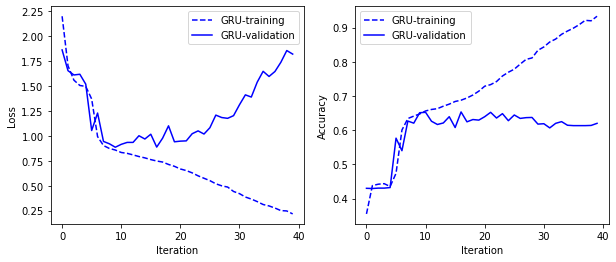

In [43]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(gru_history.history["loss"], label="GRU-training", color="blue", linestyle="dashed")
plt.plot(gru_history.history["val_loss"], label="GRU-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(gru_history.history["accuracy"], label="GRU-training", color="blue", linestyle="dashed")
plt.plot(gru_history.history["val_accuracy"], label="GRU-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Macro-f1 score

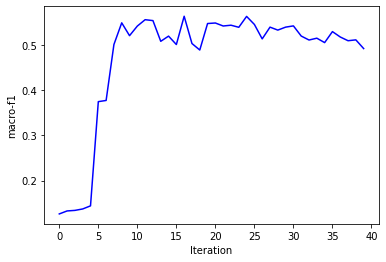

In [44]:
plt.plot(metrics.f1s, color="blue")
plt.xlabel("Iteration")
plt.ylabel("macro-f1")
plt.show()

Load best model

In [45]:
os.listdir(checkpoint_dir)[:3]

['cp-0006.ckpt', 'cp-0038.ckpt', 'cp-0013.ckpt']

In [47]:
print(np.argmax(metrics.f1s)+1)
metrics.f1s[np.argmax(metrics.f1s)]

17


0.5637848177792882

In [48]:
models_path

'/models'

#####Load best model

In [49]:
model = keras.models.load_model(os.path.join(models_path, "cp-0017.ckpt"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 8ms/step - loss: 0.8421 - accuracy: 0.6695
training loss: 0.7265549898147583 training accuracy 0.6968333125114441
test loss: 0.84206223487854 test accuracy 0.6694999933242798


In [50]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.7091    0.8298    0.7647       282
           2     0.4034    0.3529    0.3765       136
           3     0.4852    0.3868    0.4304       212
           4     0.5593    0.3541    0.4336       466
           5     0.7452    0.8960    0.8137       904

    accuracy                         0.6695      2000
   macro avg     0.5804    0.5639    0.5638      2000
weighted avg     0.6460    0.6695    0.6479      2000



evaluate.py

In [54]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(len(pred))
# save model validation predictions
pred_df = pd.DataFrame({'stars': pred, 'review_id': valid_df['review_id']})
pred_df.to_csv('valid_pred.csv', index=False)

2000


In [58]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

ans = pd.read_csv(data_dir+"/valid.csv", usecols=["review_id", "stars"])
pred = pd.read_csv("valid_pred.csv", usecols=["review_id", "stars"])
df = pd.merge(ans, pred, how="left", on=["review_id"])
df.fillna(0, inplace=True)
acc = accuracy_score(df["stars_x"], df["stars_y"])
p, r, f1, _ = precision_recall_fscore_support(df["stars_x"], df["stars_y"], average="macro")
print("accuracy:", acc, "\tprecision:", p, "\trecall:", r, "\tf1:", f1)

accuracy: 0.6695 	precision: 0.5804303162622035 	recall: 0.5639231631354517 	f1: 0.5637848177792882


#####Final prediction

In [59]:
pred = np.argmax(model.predict(test_feats_matrix), axis = 1) + 1
print(len(pred))
# save your model predictions
pred_df = pd.DataFrame({'stars': pred, 'review_id': test_df['review_id']})
pred_df.to_csv('pred.csv', index=False)

4000


####LSTM+Word2Vec

In [60]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=50, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 7ms/step - loss: 0.8318 - accuracy: 0.6620
training loss: 0.784489095211029 training accuracy 0.6696110963821411
test loss: 0.8318044543266296 test accuracy 0.6620000004768372


In [61]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.6703    0.8652    0.7554       282
           2     0.3671    0.2132    0.2698       136
           3     0.4387    0.4387    0.4387       212
           4     0.5472    0.4356    0.4851       466
           5     0.7752    0.8352    0.8040       904

    accuracy                         0.6620      2000
   macro avg     0.5597    0.5576    0.5506      2000
weighted avg     0.6438    0.6620    0.6478      2000



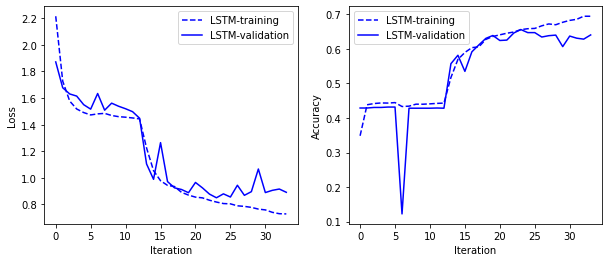

In [62]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

####BiLSTM+Word2Vec


In [63]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 13ms/step - loss: 0.8684 - accuracy: 0.6360
training loss: 0.679492175579071 training accuracy 0.7227222323417664
test loss: 0.8683652281761169 test accuracy 0.6359999775886536


In [64]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.6648    0.8227    0.7353       282
           2     0.3485    0.3382    0.3433       136
           3     0.3725    0.4340    0.4009       212
           4     0.5034    0.3176    0.3895       466
           5     0.7710    0.8341    0.8013       904

    accuracy                         0.6360      2000
   macro avg     0.5320    0.5493    0.5340      2000
weighted avg     0.6227    0.6360    0.6224      2000



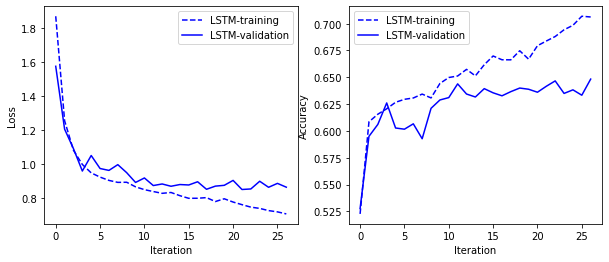

In [65]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(bilstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(bilstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Diverged already -> maybe not good

####GRU+GloVe


Load GloVe

In [68]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2022-09-03 04:40:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-03 04:40:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-03 04:40:29--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [69]:
path_to_glove_file = os.path.join('','glove.6B.100d.txt')

embedding_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding_index[word] = coefs

print("Found %s word vectors." % len(embedding_index))

Found 400000 word vectors.


Build Embedding matrix

In [70]:
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((len(feats_dict), embedding_dim))
for word, i in feats_dict.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 32198 words (13421 misses)


In [71]:
embedding_matrix[:5]

array([[-4.65390012e-02,  6.19660020e-01,  5.66470027e-01,
        -4.65840012e-01, -1.18900001e+00,  4.45989996e-01,
         6.60350025e-02,  3.19099993e-01,  1.46789998e-01,
        -2.21190006e-01,  7.92389989e-01,  2.99050003e-01,
         1.60730004e-01,  2.53240000e-02,  1.86780006e-01,
        -3.10009986e-01, -2.81080008e-01,  6.05149984e-01,
        -1.06540000e+00,  5.24760008e-01,  6.41520023e-02,
         1.03579998e+00, -4.07790005e-01, -3.80109996e-01,
         3.08010012e-01,  5.99640012e-01, -2.69910008e-01,
        -7.60349989e-01,  9.42219973e-01, -4.69190001e-01,
        -1.82779998e-01,  9.06520009e-01,  7.96710014e-01,
         2.48249993e-01,  2.57129997e-01,  6.23199999e-01,
        -4.47679996e-01,  6.53569996e-01,  7.69020021e-01,
        -5.12290001e-01, -4.43329990e-01, -2.18669996e-01,
         3.83700013e-01, -1.14830005e+00, -9.43979979e-01,
        -1.50619999e-01,  3.00119996e-01, -5.78059971e-01,
         2.01749995e-01, -1.65910006e+00, -7.91950002e-0

In [72]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="gru", num_rnn_layers=1, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix,
                  activation="softmax",
                  optimizer="RMSprop",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  gru_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=40, batch_size=100, verbose=0,
                    callbacks=[checkpointer, metrics])#earlystopping, metrics])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])


macro-f1:  0.12451790633608817

macro-f1:  0.12451790633608817

macro-f1:  0.12451790633608817

macro-f1:  0.12451790633608817

macro-f1:  0.2720296457693704

macro-f1:  0.2980424171918556

macro-f1:  0.34733969867493436

macro-f1:  0.4471299062700891

macro-f1:  0.4212581115279967

macro-f1:  0.4692524819151873

macro-f1:  0.4583051073241845

macro-f1:  0.47339258506016774

macro-f1:  0.5036595919709811

macro-f1:  0.5362698744938867

macro-f1:  0.49546447975611035

macro-f1:  0.5260135886503735

macro-f1:  0.5326199004556702

macro-f1:  0.5435462840699865

macro-f1:  0.469109822182852

macro-f1:  0.496522760617552

macro-f1:  0.47987468002050654

macro-f1:  0.5121016131561124

macro-f1:  0.5322546729568367

macro-f1:  0.5022609898481738

macro-f1:  0.5193653808257459

macro-f1:  0.48920279770858566

macro-f1:  0.49510611760699985

macro-f1:  0.49982936023770874

macro-f1:  0.5078752092773424

macro-f1:  0.5220421761516005

macro-f1:  0.4874552571179243

macro-f1:  0.518499761801922


In [73]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.7055    0.8156    0.7566       282
           2     0.3636    0.2647    0.3064       136
           3     0.4076    0.3538    0.3788       212
           4     0.4717    0.4120    0.4399       466
           5     0.7480    0.8142    0.7797       904

    accuracy                         0.6345      2000
   macro avg     0.5393    0.5321    0.5323      2000
weighted avg     0.6154    0.6345    0.6226      2000



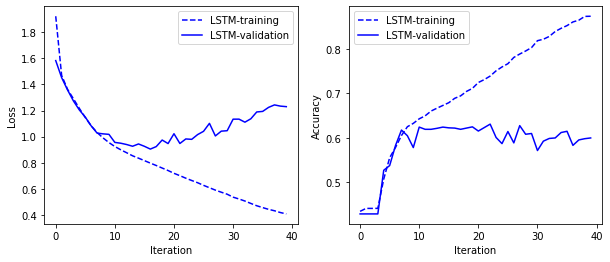

In [74]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(gru_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(gru_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(gru_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(gru_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

No signal for GloVe